***Installing kaggle to download website***

In [ ]:
! pip install kaggle

***Installing VIT and KERAS***

In [ ]:
!pip install kaggle vit-keras tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.0 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.3.1 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


***Importing necessary libraries***

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
import numpy as np
from sklearn.metrics import classification_report
from vit_keras import vit
from sklearn.model_selection import train_test_split
import shutil

# Enable mixed precision training....FOr reduce memory usage and improve performance
tf.keras.mixed_precision.set_global_policy('mixed_float16')


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


***Below cells are just to connect google colab with kaggle API***

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
! mkdir ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json


cp: cannot stat '/content/drive/MyDrive/kaggle.json': No such file or directory


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


***Downloading the kaggle datasets***

In [ ]:
! kaggle datasets download rupeshmahanty/pneumonia-tuberculosis-normal

Dataset URL: https://www.kaggle.com/datasets/rupeshmahanty/pneumonia-tuberculosis-normal
License(s): CC0-1.0
100% 567M/567M [00:34<00:00, 15.4MB/s]
100% 567M/567M [00:34<00:00, 17.4MB/s]


***The file downloaded as ZIP so im unzipping it***

In [ ]:
!unzip /content/pneumonia-tuberculosis-normal.zip

Archive:  /content/pneumonia-tuberculosis-normal.zip
  inflating: Test/NORMAL/IM-0115-0001.jpeg  
  inflating: Test/NORMAL/IM-0117-0001.jpeg  
  inflating: Test/NORMAL/IM-0119-0001.jpeg  
  inflating: Test/NORMAL/IM-0122-0001.jpeg  
  inflating: Test/NORMAL/IM-0125-0001.jpeg  
  inflating: Test/NORMAL/IM-0127-0001.jpeg  
  inflating: Test/NORMAL/IM-0128-0001.jpeg  
  inflating: Test/NORMAL/IM-0129-0001.jpeg  
  inflating: Test/NORMAL/IM-0133-0001.jpeg  
  inflating: Test/NORMAL/IM-0135-0001.jpeg  
  inflating: Test/NORMAL/IM-0137-0001.jpeg  
  inflating: Test/NORMAL/IM-0140-0001.jpeg  
  inflating: Test/NORMAL/IM-0141-0001.jpeg  
  inflating: Test/NORMAL/IM-0143-0001.jpeg  
  inflating: Test/NORMAL/IM-0145-0001.jpeg  
  inflating: Test/NORMAL/IM-0147-0001.jpeg  
  inflating: Test/NORMAL/IM-0151-0001.jpeg  
  inflating: Test/NORMAL/IM-0152-0001.jpeg  
  inflating: Test/NORMAL/IM-0154-0001.jpeg  
  inflating: Test/NORMAL/IM-0156-0001.jpeg  
  inflating: Test/NORMAL/IM-0158-0001.jpeg  
  

**Copying images to the directories**

In [ ]:
import os
import shutil

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Base directory for the new structure
base_dir = '/content/drive/MyDrive/split_data'
all_dir = os.path.join(base_dir, 'all')
os.makedirs(all_dir, exist_ok=True)

# Paths to the original data directories
original_train_dir = os.path.join('/content/Train')

# Copy the original training data into the new "all" directory
for category in ['TUBERCULOSIS', 'PNEUMONIA', 'NORMAL']:
    os.makedirs(os.path.join(all_dir, category), exist_ok=True)

    category_dir = os.path.join(original_train_dir, category)
    images = os.listdir(category_dir)

    for image in images:
        shutil.copy(os.path.join(category_dir, image), os.path.join(all_dir, category, image))

print("Images copied successfully!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


***Also copying the test files***

In [ ]:
original_train_dir = os.path.join('/content/Test')

# Copy the original training data into the new "all" directory
for category in ['TUBERCULOSIS', 'PNEUMONIA', 'NORMAL']:
    os.makedirs(os.path.join(all_dir, category), exist_ok=True)

    category_dir = os.path.join(original_train_dir, category)
    imagess = os.listdir(category_dir)

    for image in imagess:
        shutil.copy(os.path.join(category_dir, image), os.path.join(all_dir, category, image))

print("Images copied successfully!")


***Making directories for the train, test and validation***

In [ ]:
import os
import shutil
from google.colab import drive
from sklearn.model_selection import train_test_split
# Mount Google Drive
drive.mount('/content/drive')

# Base directory for the new structure
base_dir = '/content/drive/MyDrive/split_data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

print("Train, validation, and test directories created successfully!")


Mounted at /content/drive
Train, validation, and test directories created successfully!


***Splitting images to train, test and validation***

In [ ]:
# Paths to the original data directories
original_train_dir = os.path.join('/content/drive/MyDrive/split_data/all') # updated path

# Split the original training data into new training, validation, and test sets
for category in ['TUBERCULOSIS', 'PNEUMONIA', 'NORMAL']: # updated line
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)
    os.makedirs(os.path.join(test_dir, category), exist_ok=True) # added line

    category_dir = os.path.join(original_train_dir, category)
    images = os.listdir(category_dir)
    train_images, temp_images = train_test_split(images, test_size=0.3, random_state=42)
    test_images, val_images = train_test_split(temp_images, test_size=0.5, random_state=42)

    for image in train_images:
        shutil.copy(os.path.join(category_dir, image), os.path.join(train_dir, category, image))

    for image in val_images:
        shutil.copy(os.path.join(category_dir, image), os.path.join(val_dir, category, image))

    for image in test_images:
        shutil.copy(os.path.join(category_dir, image), os.path.join(test_dir, category, image))

print("Images split and copied successfully!")

***data preprocessing part started***

In [ ]:
batch_size = 8



# Define input shape and number of classes
input_shape = (272, 272, 3)
num_classes = 3
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    #brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)
val_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 1547 images belonging to 3 classes.
Found 332 images belonging to 3 classes.
Found 331 images belonging to 3 classes.


**For saving the model and history**

In [ ]:
import pickle
import tensorflow as tf

class SaveHistory(tf.keras.callbacks.Callback):
    def __init__(self, filepath):
        super(SaveHistory, self).__init__()
        self.filepath = filepath

    def on_epoch_end(self, epoch, logs=None):
        # Save the history after each epoch
        with open(self.filepath, 'wb') as file_pi:
            pickle.dump(self.model.history.history, file_pi)


*** model architure building***

347502902/347502902 [==============================] - 4s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 17, 17
  warnings.warn(


194/194 [==============================] - ETA: 0s - loss: 1.1927 - accuracy: 0.4712
Epoch 1: val_loss improved from inf to 1.17752, saving model to /content/drive/MyDrive/split_data/model_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


194/194 [==============================] - 1149s 6s/step - loss: 1.1927 - accuracy: 0.4712 - val_loss: 1.1775 - val_accuracy: 0.5392 - lr: 1.0000e-06


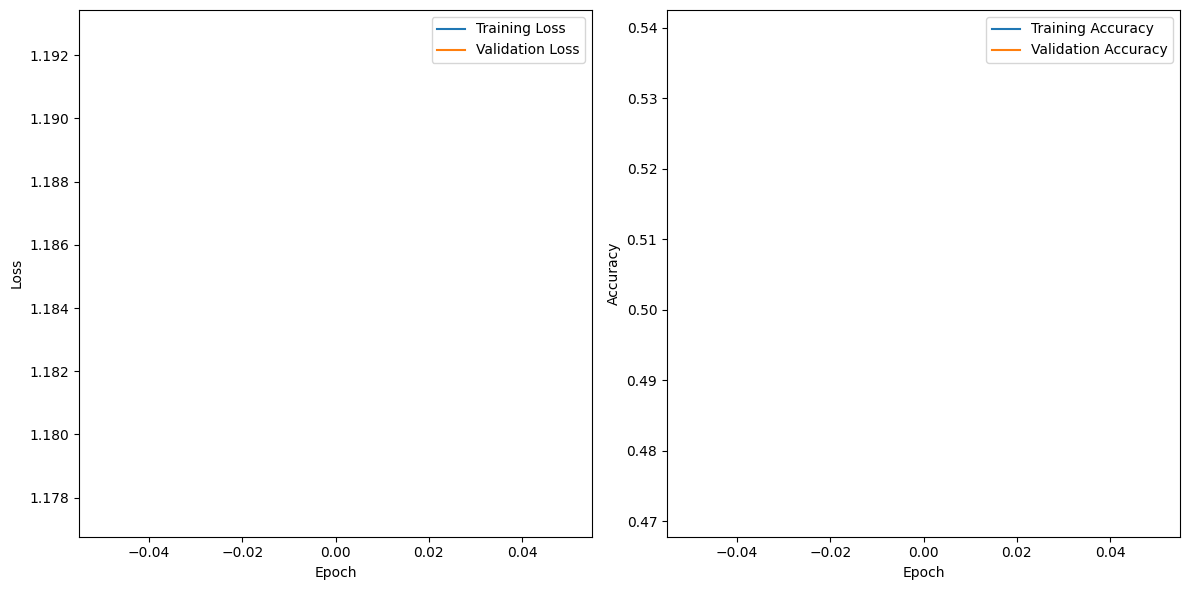

42/42 [==============================] - 12s 209ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.07      0.12       112
           1       0.42      0.93      0.58       114
           2       0.97      0.53      0.69       105

    accuracy                           0.51       331
   macro avg       0.60      0.51      0.46       331
weighted avg       0.59      0.51      0.46       331

Evaluation results:
  Loss: 1.1817
  Accuracy: 51.36%


In [ ]:
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import pickle
import random
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'


# Define the ViT model
vit_model = vit.vit_b16(
    image_size=input_shape[0],
    activation='softmax',
    pretrained='imagenet',
    include_top=False,
    pretrained_top=False,
)
dropout_rate=0.1
# Add a new classification head
inputs = Input(shape=input_shape)
x = vit_model(inputs)
x = Flatten()(x)

x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)



x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)


x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)


x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)


x = Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)


x = Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)


x = Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)



predictions = Dense(num_classes, activation='softmax', dtype='float32')(x)

# Create the new model
model = Model(inputs=inputs, outputs=predictions)

# Set up the optimizer and compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])



# Set up the callbacks
checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/MyDrive/split_data/model_checkpoint.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)



# Set up the callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    min_lr=5e-9
)

# Custom callback to save history per epoch
save_history = SaveHistory(filepath='/content/drive/MyDrive/split_data/training_history.pkl')

# Train the model
history = model.fit(
    train_generator,
    epochs=1,
    validation_data=val_generator,
    callbacks=[checkpoint_callback, early_stopping, reduce_lr, save_history]
)
# Load and continue training as needed

# Save the history
with open('initial_history.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

# Plot learning curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_generator)

# Get the predicted labels for the test set
test_generator.reset()
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

# Get the true labels for the test set
y_true = test_generator.classes

# Compute the classification report (including precision, recall, F1-score)
classification_rep = classification_report(y_true, y_pred)
print("Classification Report:")
print(classification_rep)

print("Evaluation results:")
print(f"  Loss: {loss:.4f}")
print(f"  Accuracy: {accuracy:.2%}")
#l2=1e-5, batch=32, minlr=1e-6
#l2=1e-4, batch=16, , minlr=1e-5
#3

***I have already trained the model thats why im not training it again,,,im just loading it***

In [ ]:
! kaggle datasets download siamislam444/finalmodel

Dataset URL: https://www.kaggle.com/datasets/siamislam444/finalmodel
License(s): CC0-1.0
100% 1.79G/1.79G [01:43<00:00, 17.6MB/s]
100% 1.79G/1.79G [01:43<00:00, 18.5MB/s]


***unzip the zipped file***

In [ ]:
!unzip /content/finalmodel.zip

Archive:  /content/finalmodel.zip
  inflating: finalmodel1.h5          
  inflating: initial_history.pkl     
  inflating: model_checkpoint.h5     
  inflating: training_history.pkl    


***load the history***

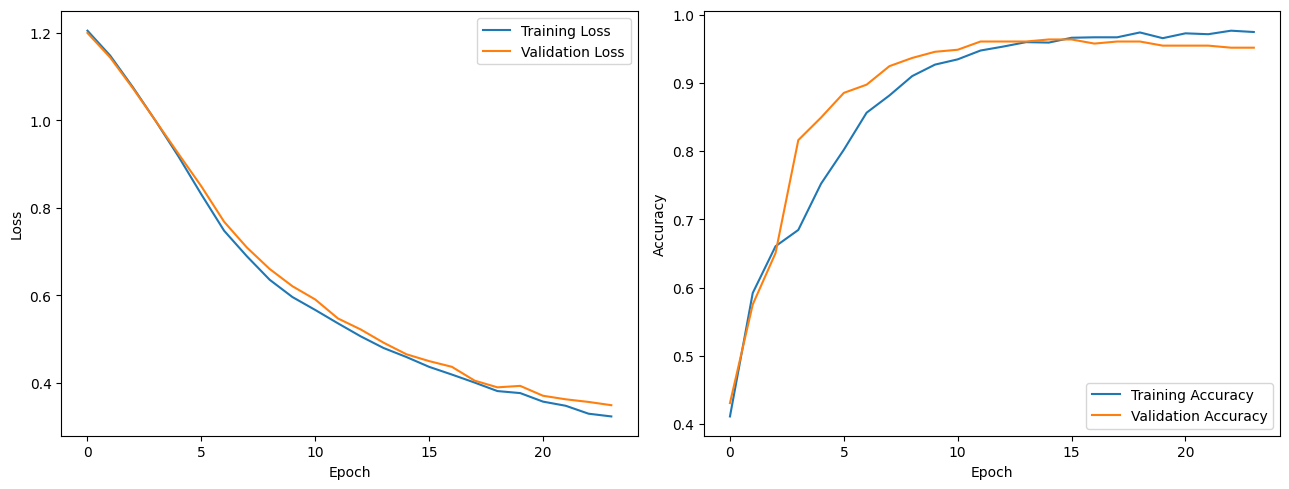

In [ ]:
from tensorflow.keras.models import Model, load_model
import pickle
with open('/content/training_history.pkl', 'rb') as file_pi:
    history_data = pickle.load(file_pi)
# Plot the combined history
plt.figure(figsize=(13, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history_data['loss'], label='Training Loss')
plt.plot(history_data['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history_data['accuracy'], label='Training Accuracy')
plt.plot(history_data['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

***Loading the model***

In [ ]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('/content/finalmodel1.h5')

# Evaluate the loaded model on the test set
loss, accuracy = model.evaluate(test_generator)

print("Evaluation results of the loaded model:")
print(f"  Loss: {loss:.4f}")
print(f"  Accuracy: {accuracy:.2%}")


42/42 [==============================] - 12s 208ms/step - loss: 0.3419 - accuracy: 0.9637
Evaluation results of the loaded model:
  Loss: 0.3419
  Accuracy: 96.37%


In [ ]:
for layer in model.layers:
    print(layer.name, layer.output_shape)


input_12 [(None, 272, 272, 3)]
vit-b16 (None, 768)
flatten_5 (None, 768)
dense_40 (None, 512)
dense_41 (None, 256)
dense_42 (None, 128)
dense_43 (None, 64)
dense_44 (None, 32)
dense_45 (None, 16)
dense_46 (None, 8)
dense_47 (None, 3)


Generating the classification report, confusion matrix

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
42/42 [==============================] - 9s 215ms/step - loss: 0.3419 - accuracy: 0.9637
Test Loss: 0.3419
Test Accuracy: 96.3746%
42/42 [==============================] - 9s 212ms/step
Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.91      1.00      0.95       112
   PNEUMONIA       0.99      0.92      0.95       114
TUBERCULOSIS       1.00      0.97      0.99       105

    accuracy                           0.96       331
   macro avg       0.97      0.96      0.96       331
weighted avg       0.97      0.96      0.96       331



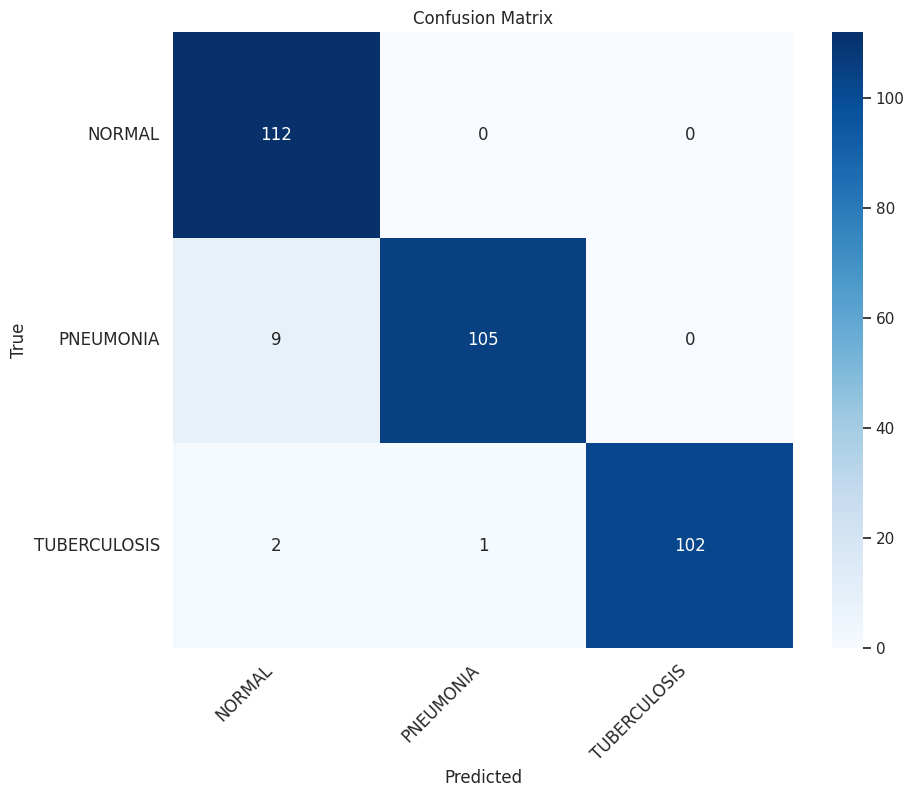

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4%}")

# Get the predicted labels for the test set
test_generator.reset()
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

# Get the true labels for the test set
y_true = test_generator.classes

# Compute the classification report (including precision, recall, F1-score)
class_indices = test_generator.class_indices
class_labels = list(class_indices.keys())
classification_rep = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:")
print(classification_rep)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.set(font_scale=1)  # Adjust to scale font if needed
heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=12)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title('Confusion Matrix', fontsize=12)

# Save the figure as SVG format to Google Drive
plt.savefig('/content/drive/MyDrive/confusion_matrix.svg', format='svg')

plt.show()


***Generating AUC-ROC curve***

42/42 [==============================] - 9s 218ms/step


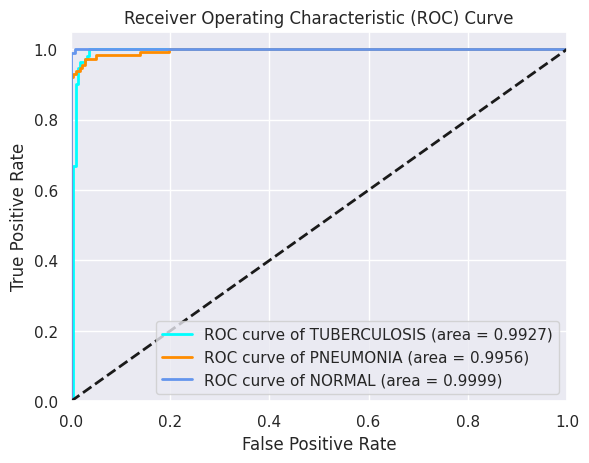

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Define the class names (replace these with your actual class names if different)
class_names = ['TUBERCULOSIS', 'PNEUMONIA', 'NORMAL']

# Get the true labels and predicted probabilities
y_true = test_generator.classes
y_pred_proba = model.predict(test_generator)

# Binarize the true labels for multi-class ROC AUC
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])  # Adjust classes if necessary

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(class_names)  # Number of classes

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label='ROC curve of {0} (area = {1:.4f})'.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Save the plot as an SVG file
plt.savefig('roc_curve.svg', format='svg')

plt.show()


Installing SHAP

In [ ]:
!pip install shap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 40.6 MB/s eta 0:00:00


applying shap

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


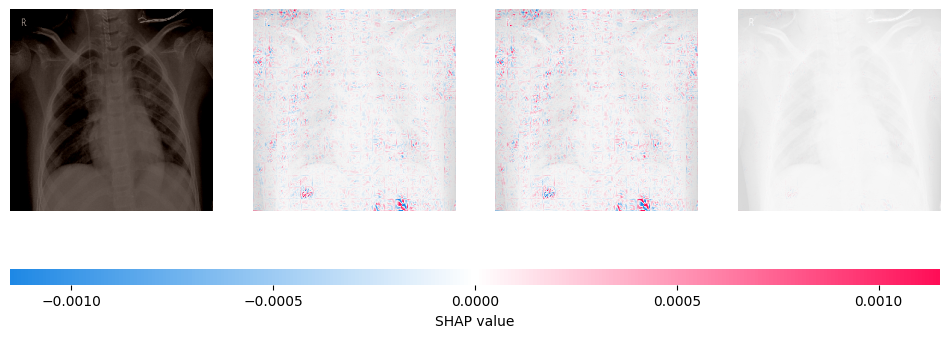

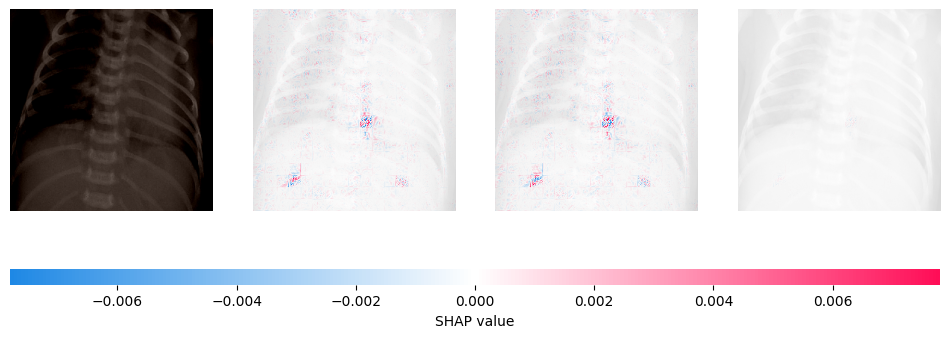

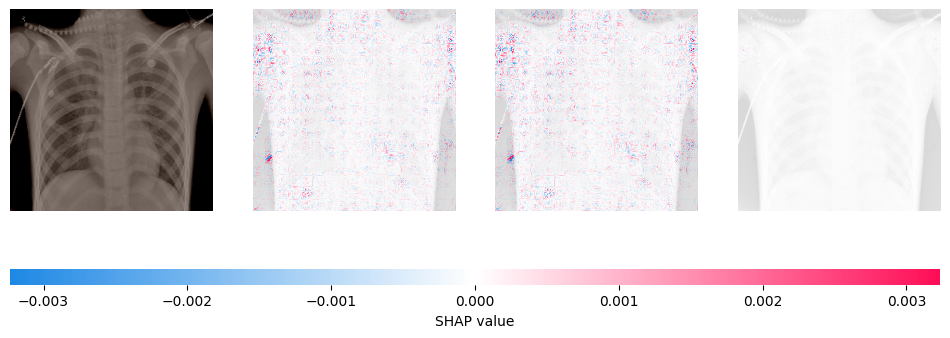

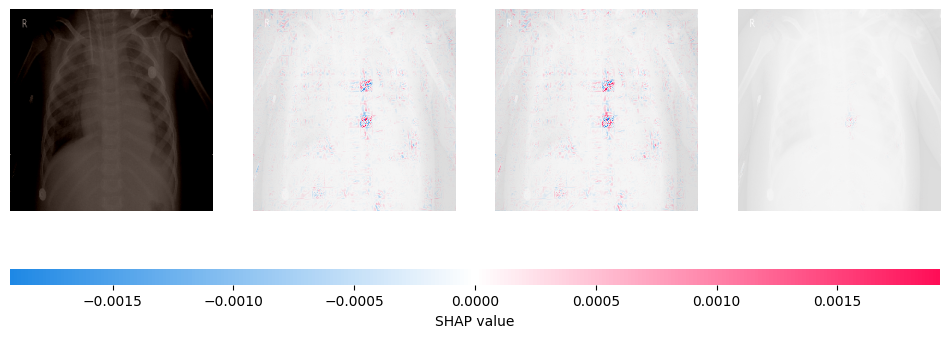

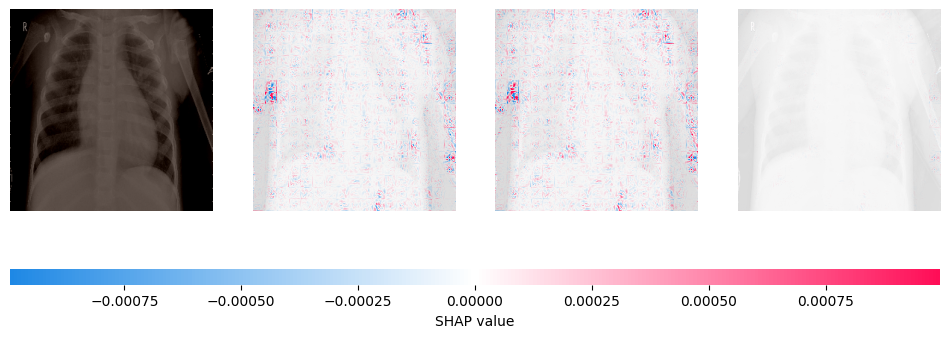

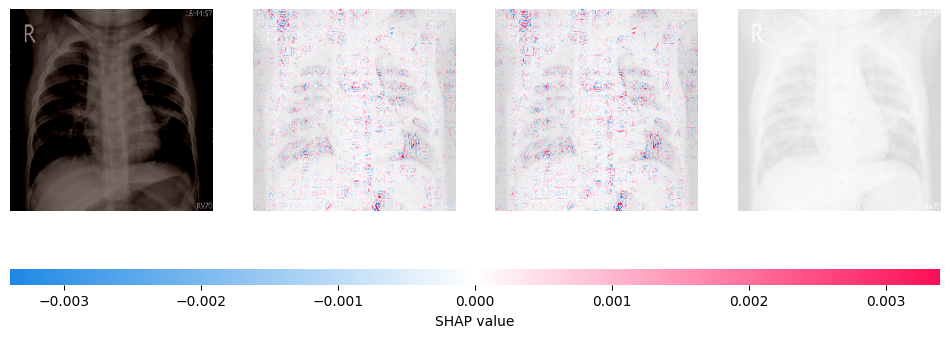

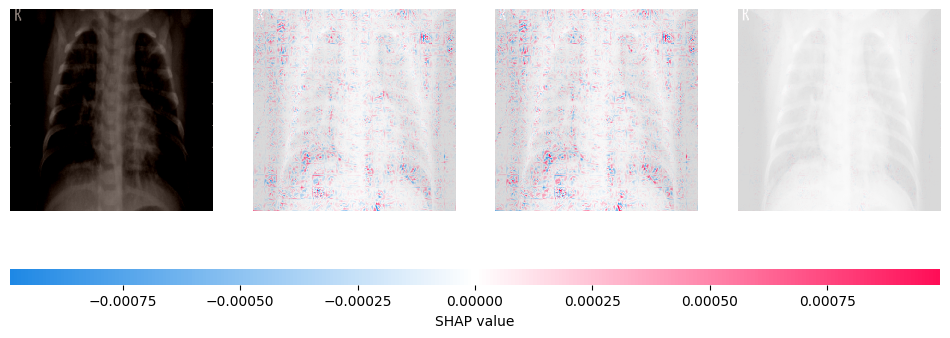

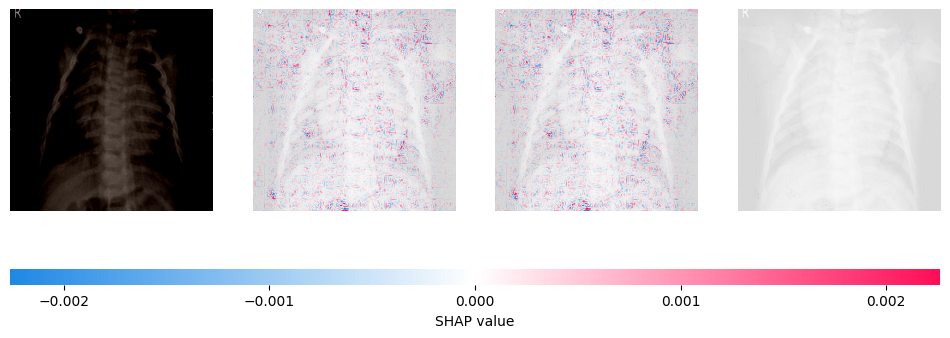

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Assuming the test_generator and model are already defined and loaded

# Skip the first 99 batches
for _ in range(99):
    val_generator.next()

# Take a batch of test data
X_test, y_test = next(val_generator)
X_test = X_test[:2]  # Take 2 samples for demonstration

# Create a SHAP explainer using the model
explainer = shap.GradientExplainer(model, X_test)
# Compute SHAP values
shap_values = explainer.shap_values(X_test)

# Visualize and save the SHAP values for each image in the batch
for i in range(len(X_test)):
    fig, ax = plt.subplots(figsize=(8, 8))  # Set the figure size to be square (8x8)
    shap.image_plot([shap_values[j][i] for j in range(len(shap_values))], np.squeeze(X_test[i:i+1]), show=False)
    plt.axis('off')  # Hide axes for a cleaner image
    plt.savefig(f'shap_plot_{i}.png', bbox_inches='tight', pad_inches=0, format='png', dpi=200)
    plt.close(fig)


***Applying LIME***

In [ ]:
pip install LIME
import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Function to get the class labels
class_labels = list(train_generator.class_indices.keys())

# Initialize the LIME explainer
explainer = lime_image.LimeImageExplainer()

# Function to make predictions
def predict_fn(images):
    images = np.array(images)
    return model.predict(images)

# Function to generate LIME explanation for a single image
def generate_lime_explanation(image_index, sample_image, sample_label):
    # Get the model's prediction for the sample image
    predictions = model.predict(np.expand_dims(sample_image, axis=0))
    predicted_class = np.argmax(predictions, axis=1)[0]
    predicted_class_label = class_labels[predicted_class]

    # Get the actual class label
    actual_class_label = class_labels[np.argmax(sample_label)]

    print(f"Predicted class: {predicted_class_label}")
    print(f"Actual class: {actual_class_label}")

    # Explain the prediction on the sample image
    explanation = explainer.explain_instance(
        sample_image.astype('double'),
        predict_fn,
        top_labels=3,
        hide_color=0,
        num_samples=3000  # Reduced for faster computation
    )

    # Get the explanation for the top predicted class
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=3,
        hide_rest=False
    )

    # Create a figure with two subplots in a row
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Original X-ray image
    axes[0].imshow(sample_image / 2 + 0.5)
    axes[0].set_title('Original X-ray Image')
    axes[0].axis('off')

    # LIME explanation
    axes[1].imshow(mark_boundaries(temp / 2 + 0.5, mask))
    axes[1].set_title(f'Explanation for class: {predicted_class_label}')
    axes[1].axis('off')

    # Save the figure as SVG
    svg_filename = f"lime_explanation_{predicted_class_label}_{image_index}.svg"
    plt.savefig(svg_filename, format='svg')
    plt.show()

# Skip the first 99 batches
for _ in range(99):
    val_generator.next()

# Load the 100th batch of images from the validation set
sample_images, sample_labels = val_generator.next()

# Generate explanations for each image in the 100th batch
for i in range(len(sample_images)):
    generate_lime_explanation(i, sample_images[i], sample_labels[i])
